In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random

import matplotlib.pyplot as plt
import time

from model import ConvNet

from fasttext.CustomDataset import get_dataset
from fasttext.CustomDataset import vec_trans

/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/nfs4/ushashi/anaconda3/envs/gp

In [2]:
random.seed(20)
np.random.seed(20)


NUM_MAPS = 4*60*6

LOG_SOFTMAX_VALUES = False

dset = get_dataset('data/test.csv')

FILE = 'fasttext/weights_2/Model_quicksave5.pt'

print('''
0 - World
1 - Sports
2 - Business
3 - Sci/Tech
''')

rand_files = random.sample(range(len(dset)), NUM_MAPS)


0 - World
1 - Sports
2 - Business
3 - Sci/Tech



In [3]:
model = ConvNet(LOG_SOFTMAX_VALUES, WINDOW=3)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on',device)
print('Building model..')
model.to(device)
print('Model Built.')

model.load_state_dict(torch.load(FILE,map_location='cuda:0'))#,map_location='cuda:0'))
model.eval()


print('Printing Parameters')
for name, param in model.named_parameters():
    param.requires_grad = False
    print(name)

print('---Printing Parameters Finished!---')

Running on cuda:0
Building model..
Model Built.
Printing Parameters
conv1.weight
conv1.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias
---Printing Parameters Finished!---


In [4]:
def comp_loss(mod, org, h, mode):
    '''
    Computes Loss Function
    '''
    ### Loss 1
    if mode == 1:
        z = torch.mean((mod[:,h]-org[:,h])**2)
    
    ### Loss 2
    if mode == 2:
        z = torch.mean((mod[:,:]-org[:,:])**2)
    
    ### Loss 3
    if mode == 3:
        z = mod-org
        z[:,h] = F.relu(org[:,h]-mod[:,h])
        z = torch.mean((F.relu(z))**2)
    
    ### Loss 4
    if mode == 4:
        z = mod-org
        z[:,h] = org[:,h]-mod[:,h]
        z = torch.mean(z)
    
    
    return z

In [5]:
from matplotlib import cm, transforms

def plot_text_heatmap(words, scores, norm=0, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    
    fig = plt.figure(figsize=(width, height))
    ax = plt.gca()
    ax.set_title(title, loc='left')
    tokens = words
    
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    if norm == 0:
        normalized_scores =  scores #/ np.max(np.abs(scores))
    elif norm == 1:
        normalized_scores =  0.5*scores/np.max(np.abs(scores)) + 0.5
    elif norm == 2:
        normalized_scores =  0.5*(scores/np.max(np.abs(scores))) + 0.5
        
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')


In [6]:
with open('prepositions.txt','r') as f:
    prep = [p.strip() for p in f]
    
print(prep)

['aboard', 'about', 'above', 'across', 'after', 'against', 'along', 'amid', 'among', 'anti', 'around', 'as', 'at', 'before', 'behind', 'below', 'beneath', 'beside', 'besides', 'between', 'beyond', 'but', 'by', 'despite', 'down', 'during', 'except', 'for', 'from', 'in', 'inside', 'into', 'like', 'near', 'of', 'off', 'on', 'onto', 'outside', 'over', 'past', 'per', 'regarding', 'save', 'since', 'than', 'through', 'to', 'toward', 'under', 'underneath', 'unlike', 'until', 'up', 'upon', 'via', 'with', 'within', 'without', 'is', 'was', 'a', 'an', 'the']


In [7]:
def GenRelMap_GreedyOpt_Fast(x, indices, num=12):
    
    x_input = torch.as_tensor(x).to(device, dtype = torch.float)
    x_out = model(x_input.clone()).detach()
    target = int(np.argmax(x_out.cpu().numpy(), axis=1))
    #print(target)
    
    order = [None]*num
    
    s = np.ones((1,1,x.shape[2],300))
    s = torch.as_tensor(s.astype(np.float32)).to(device)
    s.requires_grad = False
    
    n = vec_trans.matrixify('a',1)
    n = np.tile(n,(1,1,x.shape[2],1))
    
    #for i in range(64):
    #    n[i] = np.tile(vec_trans.matrixify(prep[i],1),(1,1,x.shape[2],1))
    n = torch.as_tensor(n.astype(np.float32)).to(device)
    
    for i in range(num):
        min_arg = -1
        min_acc = float('inf')
        
        for arg in indices:
            if arg in order[:i]:
                continue
            
            s[:,:,arg,:] = torch.zeros((1,1,300))
            data_input = (x_input-n)*s+n
            out = model(data_input)
            acc = torch.mean(out,dim=0)[target].cpu().numpy()#1.0*sum(temp)/64.0
            if acc<min_acc:
                min_arg = arg
                min_acc = acc
            s[:,:,arg,:] = torch.ones((1,1,300))
        
        order[i] = min_arg
        s[:,:,min_arg,:] = torch.zeros((1,1,300))
            
    return order

In [8]:
def GenRelMap_LF(x, mode, num_iters=400, lr =5e-3, gam = 0.995, lamb=750, mini=0.5,maxi=1.5):
    
    x_input = torch.as_tensor(x).to(device, dtype = torch.float)
    x_out = model(x_input.clone()).detach()
    highest_dim = int(np.argmax(x_out.cpu().numpy(), axis=1))
    
    if mode == 4:
        s = 0.5 + 0.1*np.random.rand(1,x.shape[2],1)
        s = torch.as_tensor(s.astype(np.float32)).to(device)
        s.requires_grad = True

        optimizer = optim.Adam([s], lr = lr)             # OR RAdam/DiffGrad/etc
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gam)

        n = vec_trans.matrixify('a',1)
        n = np.tile(n,(64,1,x.shape[2],1))    
        for i in range(64):
            n[i] = np.tile(vec_trans.matrixify(prep[i],1),(1,1,x.shape[2],1))
        n = torch.as_tensor(n.astype(np.float32)).to(device)

        for i in range(num_iters):
            data_input = (x_input-n)*s+n
            out = model(data_input)

            loss = 0.5*comp_loss(out, x_out, highest_dim, mode=4)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                s = s.clamp_(0,1) #- s
            scheduler.step()

        return s.detach().cpu().numpy()
    
    if mode ==2:
        dirr = 0
        inc = 15.0
        while True:
            print(lamb)
            s = 0.5+0.2*np.random.rand(1,x.shape[2],1)
            s = torch.as_tensor(s.astype(np.float32)).to(device)
            s.requires_grad = True

            optimizer = optim.Adam([s], lr = lr)             # OR RAdam/DiffGrad/etc
            scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gam)
            for i in range(num_iters):

                n = vec_trans.matrixify('a',1)
                n = np.tile(n,(64,1,x.shape[2],1))
                for po in range(64):
                    n[po] = np.tile(vec_trans.matrixify(prep[po],1),(1,1,x.shape[2],1))
                n = torch.as_tensor(n.astype(np.float32)).to(device)

                data_input = (x_input-n)*s+n
                out = model(data_input)

                loss = 0.5*comp_loss(out,x_out,highest_dim,2)+lamb*torch.mean(torch.abs(s))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                with torch.no_grad():
                    s = s.clamp_(0,1) # - s
                scheduler.step()
            #print(s.detach().cpu().numpy().mean())
            if s.detach().cpu().numpy().mean()>maxi:
                if dirr<0:
                    inc = inc/2
                    #print('A')
                lamb = lamb*(1+inc)
                dirr = 1
                #print('1')
            elif s.detach().cpu().numpy().mean()<mini:
                if dirr > 0:
                    inc = inc/2
                    #print('B')
                lamb = lamb/(1+inc)
                dirr = -1
                #print('-1')
            else:
                break
                
        return s.detach().cpu().numpy(), lamb
    
    if mode == 5:
        s = 0.1*np.random.rand(1,x.shape[2],1)
        s = torch.as_tensor(s.astype(np.float32)).to(device)
        s.requires_grad = True

        optimizer = optim.Adam([s], lr = lr)             # OR RAdam/DiffGrad/etc
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gam)
        for i in range(num_iters):

            n = vec_trans.matrixify('a',1)
            n = np.tile(n,(64,1,x.shape[2],1))
            for i in range(64):
                n[i] = np.tile(vec_trans.matrixify(prep[i],1),(1,1,x.shape[2],1))
            n = torch.as_tensor(n.astype(np.float32)).to(device)

            data_input = (x_input-n)*s+n
            out = model(data_input)

            loss = 0.5*comp_loss(out,x_out,highest_dim,2)+lamb*torch.mean(torch.abs(s))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                s += s.clamp_(0,1) - s
            scheduler.step()
        
        return s.detach().cpu().numpy()

# Relevance Map Generation

In [10]:
N_PC = 60

N_AB = 7  #Num of fixed lambda rmap
N_AD = 3  #Num of adaptive lambda rmap

LAMS = [0, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
RANG = [(0.04,0.1),(0.12,0.25),(0.25,0.45)]

rmap_f = [None]*N_AB
for i in range(N_AB):
    rmap_f[i] = [None]*4
    for j in range(4):
        rmap_f[i][j] = [0]*N_PC

rmap_a = [None]*N_AD
for i in range(N_AD):
    rmap_a[i] = [None]*4
    for j in range(4):
        rmap_a[i][j] = [0]*N_PC

        
rmap_g = [None]*4  #By Greedy Algo
rmap_l = [None]*4  #Loss 4

wds = [None]*4
pths = [None]*4

for x in range(4):
    wds[x] = [0]*N_PC
    pths[x] = [0]*N_PC
    rmap_g[x] = [0]*N_PC
    rmap_l[x] = [0]*N_PC

    
counter = [0]*4
_ = 0
c_ = 0

while not all(x == N_PC for x in counter):
    
    x = dset[rand_files[_]]
    e = x['text']
    LE = len(e)
    sample = x['matrix']
    target = int(x['class'])
    
    if len(e)<25 or len(e)>180:
        _ += 1
        continue
    
    sample = sample[None,None,:,:]
    
    x_input = torch.as_tensor(sample).to(device, dtype=torch.float)
    x_out = model(x_input.clone()).detach().cpu()
    
    _ += 1
    
    if int(np.argmax(x_out)) != target:    
        continue
        
    if counter[target] == N_PC:
        continue
    
    print(counter)
    c_ += 1
    
    ## Greedy
    ind = GenRelMap_GreedyOpt_Fast(sample, list(range(LE)), num=10)
    rel = np.zeros(sample.shape[2])
    rel[ind] = range(1,11)[::-1]
    
    rmap_g[target][counter[target]] = rel

    
    ## Fixed L
    length = 20
    for it,LAM in enumerate(LAMS):
        guider = GenRelMap_LF(sample, mode=5, num_iters=701, gam=0.995, lr = 8e-3, lamb= LAM)[0,:,0]
        guider[LE:] = np.zeros((80-LE))
        z = np.argsort(guider)[::-1]
        ind = GenRelMap_GreedyOpt_Fast(sample, z[:length], num=10)
        rel = np.zeros(sample.shape[2])
        rel[ind] = range(1,11)[::-1]
        rmap_f[it][target][counter[target]] = rel

    
    ## Adaptive L
    lamb = 20
    for it,RAN in enumerate(RANG):
        guider, lamb = GenRelMap_LF(sample, mode=2, num_iters=701, gam=0.995, lr = 5e-3, lamb=lamb, maxi=RAN[1],mini=RAN[0])
        guider = guider[0,:,0]
        guider[LE:] = np.zeros((80-LE))
        z = np.argsort(guider)[::-1]
        ind = GenRelMap_GreedyOpt_Fast(sample, z[:length], num=10)
        rel = np.zeros(sample.shape[2])
        rel[ind] = range(1,11)[::-1]
        rmap_a[it][target][counter[target]] = rel

    guider = GenRelMap_LF(sample, mode=4, num_iters=701, gam=0.995, lr = 8e-3)[0,:,0]
    guider[LE:] = np.zeros((80-LE))
    z = np.argsort(guider)[::-1]
    ind = GenRelMap_GreedyOpt_Fast(sample, z[:length], num=10)
    rel = np.zeros(sample.shape[2])
    rel[ind] = range(1,11)[::-1]
    rmap_l[target][counter[target]] = rel

        
    wds[target][counter[target]] = e
    pths[target][counter[target]] = rand_files[_-1]
    
    counter[target] += 1 
    
    if c_%20==0:
        print('##### At '+str(c_))
        np.save('relmap_data/data_greedy_'+str(c_)+'.npy',[rmap_f,rmap_a,rmap_g,rmap_l,wds,pths])

[0, 0, 0, 0]
20
20
1.25
10.625
2.236842105263158
2.236842105263158
0.13980263157894737
[1, 0, 0, 0]
20
1.25
10.625
10.625
0.6640625
0.6640625
0.04150390625
[1, 0, 1, 0]
20
20
1.25
10.625
10.625
0.6640625
[1, 0, 2, 0]
20
20
1.25
1.25
[1, 1, 2, 0]
20
320.0
37.64705882352941
37.64705882352941
2.3529411764705883
2.3529411764705883
0.14705882352941177
[1, 2, 2, 0]
20
20
1.25
1.25
0.078125
[2, 2, 2, 0]
20
1.25
10.625
2.236842105263158
2.236842105263158
0.13980263157894737
1.1883223684210527
0.2501731301939058
0.2501731301939058
0.015635820637119113
[2, 2, 2, 1]
20
20
1.25
10.625
2.236842105263158
6.430921052631579
6.430921052631579
0.4019325657894737
[2, 3, 2, 1]
20
1.25
1.25
0.078125
0.6640625
0.6640625
0.04150390625
[2, 3, 2, 2]
20
1.25
10.625
2.236842105263158
0.4709141274238227
1.3538781163434903
1.3538781163434903
0.08461738227146814
0.7192477493074793
0.7192477493074793
0.044952984331717454
[3, 3, 2, 2]
20
20
1.25
10.625
10.625
0.6640625
[4, 3, 2, 2]
20
1.25
10.625
2.236842105263158
2.

0.025120785361842105
[22, 15, 14, 24]
20
20
1.25
1.25
0.078125
[22, 16, 14, 24]
20
20
1.25
1.25
0.078125
[22, 17, 14, 24]
20
1.25
10.625
2.236842105263158
2.236842105263158
0.13980263157894737
1.1883223684210527
1.1883223684210527
0.07427014802631579
[23, 17, 14, 24]
20
1.25
10.625
10.625
0.6640625
0.6640625
0.04150390625
[23, 17, 15, 24]
20
20
1.25
10.625
10.625
0.6640625
##### At 80
[24, 17, 15, 24]
20
20
1.25
1.25
0.078125
[25, 17, 15, 24]
20
1.25
10.625
2.236842105263158
2.236842105263158
0.13980263157894737
1.1883223684210527
1.1883223684210527
0.07427014802631579
[25, 17, 16, 24]
20
1.25
10.625
10.625
0.6640625
0.6640625
0.04150390625
[25, 18, 16, 24]
20
20
1.25
10.625
10.625
0.6640625
[25, 19, 16, 24]
20
20
1.25
1.25
0.078125
[25, 20, 16, 24]
20
1.25
10.625
2.236842105263158
6.430921052631579
6.430921052631579
0.4019325657894737
3.416426809210526
0.7192477493074791
0.7192477493074791
0.04495298433171745
[25, 20, 17, 24]
20
320.0
37.64705882352941
37.64705882352941
2.352941176470

0.13980263157894737
0.13980263157894737
0.00873766447368421
[40, 35, 42, 46]
20
1.25
10.625
2.236842105263158
6.430921052631579
6.430921052631579
0.4019325657894737
0.4019325657894737
[40, 35, 43, 46]
20
1.25
10.625
2.236842105263158
6.430921052631579
6.430921052631579
0.4019325657894737
3.416426809210526
0.7192477493074791
0.7192477493074791
0.04495298433171745
[40, 35, 43, 47]
20
1.25
10.625
2.236842105263158
6.430921052631579
6.430921052631579
0.4019325657894737
0.4019325657894737
0.025120785361842105
[40, 35, 43, 48]
20
1.25
10.625
10.625
0.6640625
5.64453125
1.1883223684210527
1.1883223684210527
0.07427014802631579
[40, 35, 44, 48]
20
1.25
10.625
10.625
0.6640625
0.6640625
0.04150390625
[40, 35, 45, 48]
20
1.25
1.25
0.078125
0.6640625
0.6640625
0.04150390625
[40, 35, 46, 48]
20
1.25
1.25
0.078125
0.6640625
0.6640625
0.04150390625
[41, 35, 46, 48]
20
1.25
10.625
10.625
0.6640625
0.6640625
0.04150390625
[41, 36, 46, 48]
20
20
1.25
1.25
0.078125
[42, 36, 46, 48]
20
320.0
37.647058823

In [11]:
np.save('relmap-Ablation.npy',[rmap_f,rmap_a,rmap_g,rmap_l,wds,pths])

In [9]:
[rmap_f,rmap_a,rmap_g,rmap_l,wds,pths] = np.load('relmap-Ablation.npy',allow_pickle=True)

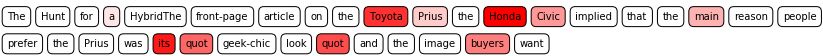

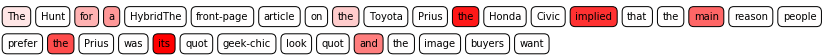

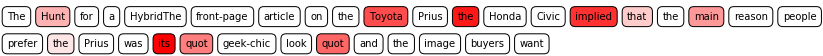

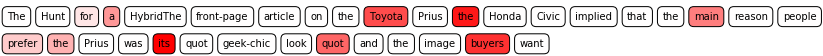

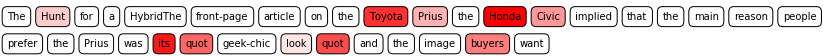

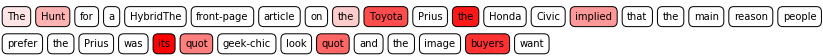

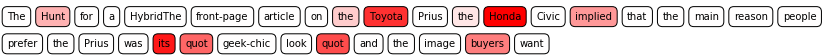

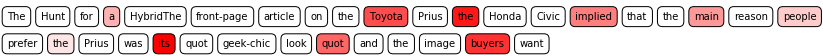

In [14]:
x = wds[2][41]

plot_text_heatmap(x,rmap_g[2][41],norm=1)


plot_text_heatmap(x,rmap_f[0][2][41],norm=1)
plot_text_heatmap(x,rmap_f[1][2][41],norm=1)
plot_text_heatmap(x,rmap_f[4][2][41],norm=1)

plot_text_heatmap(x,rmap_a[0][2][41],norm=1)
plot_text_heatmap(x,rmap_a[1][2][41],norm=1)
plot_text_heatmap(x,rmap_a[2][2][41],norm=1)

plot_text_heatmap(x,rmap_l[2][41],norm=1)
#print(rmap_l4[2][41])
#print(rmap_a[2][3][41])
#print(x)

In [10]:
from keras import backend as K
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Conv2D, Input, Dense, MaxPool2D, Flatten, Lambda, GlobalMaxPool2D, Dropout
from keras.models import Model
import tensorflow as tf


print(K.image_data_format())

with tf.device('/GPU:0'):
    inp = Input((None,300,1))
    x = Conv2D(1024,(3,300),activation='relu', name='conv1')(inp)
    
    x = GlobalMaxPool2D('channels_last')(x)
    x = Dense(256,name='fc1',activation='relu')(x)
    z = Dropout(0.25)(x)
    ou = Dense(32,name='fc2',activation='relu')(z)
    ou = Dropout(0.3)(ou)
    out = Dense(4,name='fc3')(ou)
    outz = Dropout(0.2)(out)
    k_model = Model(inp, outz)


trained_weights = model.state_dict()

pytorch_layers = [] # get ptroch layers names and suffixes
for x, l in zip(trained_weights, k_model.layers):
    pytorch_layers.append(x[:x.find('.')])

unique_layers = np.unique(pytorch_layers)
print(unique_layers)


for layer in unique_layers:
    weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
    biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
    if 'bn' in layer:
        running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
        running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
        W = [weights, biases, running_mean, running_var]
    elif 'fc' in layer:
        biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
        W = [weights.T, biases]
    else:
        W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
    k_model.get_layer(layer).set_weights(W)

k_model.summary()

channels_last
['conv1' 'fc1' 'fc2' 'fc3']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 300, 1)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, 1, 1024)     922624    
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1024)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 32)                8224      
_________________________________________________________________
dropout_2 (Dropout)          (None

In [11]:
import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from innvestigate.utils.tests.networks import base as network_base

In [12]:
rmin = float('+inf')
rmax = float('-inf')

for i in range(len(dset)):
    x = dset[i]['matrix']
    inf = torch.min(x)
    sup = torch.max(x)
    if inf< rmin:
        rmin = inf
        #print('A')
    if sup> rmax:
        #print('B')
        rmax = sup
        
print(rmin)
print(rmax)

tensor(-24.0467)
tensor(25.3291)


In [13]:
train_set = get_dataset('data/train.csv')

train_data = np.zeros((len(train_set),1,80,300))
for i in range(len(train_set)):
    train_data[i] = train_set[i]['matrix']

train_data = train_data.reshape((-1,80,300,1))
print(train_data.shape)

(120000, 80, 300, 1)


In [23]:
input_range = (-24.0467,25.3291)

analyzers = []


noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input


methods = [
    # NAME                    OPT.PARAMS         
    ("gradient",              {},           "Gradient"),
    #("smoothgrad",            {"noise_scale": noise_scale,"postprocess": "square"},     "SmoothGrad"),
    ("deconvnet",             {},           "Deconvnet"),
    ("guided_backprop",       {},           "Guided Backprop",),
    ("pattern.net",           {"pattern_type": "relu"}, "PatternNet"),
    ("pattern.attribution",   {"pattern_type": "relu"}, "PatternAttribution"),
    #("deep_taylor.bounded",   {"low": input_range[0],"high": input_range[1]}, "DeepTaylor"),
    ("input_t_gradient",      {},          "Input * Gradient"),
    #("integrated_gradients",  {"reference_inputs": ri},   "Integrated Gradients"),
    #("deep_lift.wrapper",     {"reference_inputs": ri},    "DeepLIFT Wrapper - Rescale"),
    #("deep_lift.wrapper",     {"reference_inputs": ri, "nonlinear_mode": "reveal_cancel"}, "DeepLIFT Wrapper - RevealCancel"),
    ("lrp.z",                 {},   "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},    "LRP-Epsilon"),
]





for method in methods:
    #print(method)
    analyzer = innvestigate.create_analyzer(method[0], k_model,neuron_selection_mode="index",**method[1]) #neuron_selection_mode="index", 
    analyzer.fit(train_data, batch_size=1024, verbose=1)
    analyzers.append(analyzer)

Epoch 1/1
118/118 [==============================] - 39s 335ms/step - loss: 4.0000 - broadcast_9_loss: 1.0000 - broadcast_10_loss: 1.0000 - broadcast_11_loss: 1.0000 - broadcast_12_loss: 1.0000
Epoch 1/1
118/118 [==============================] - 41s 348ms/step - loss: 4.0000 - broadcast_13_loss: 1.0000 - broadcast_14_loss: 1.0000 - broadcast_15_loss: 1.0000 - broadcast_16_loss: 1.0000


In [24]:
from keras.layers import Softmax
import time

test_sample_paths = [metaD[1][2][2]]

#test_sample_preds = [None]*len(test_sample_paths)

# a variable to store analysis results.
analysis = np.zeros([len(test_sample_paths), len(analyzers), 1, 80])

for i, ridx in enumerate(test_sample_paths):
    
    x = dset[ridx]['matrix']
    x = x.reshape((1, -1, 300,1))    
    x = x.numpy()
    prob = k_model.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
    #test_sample_preds[i] = y_hat
    
    
    for aidx, analyzer in enumerate(analyzers):
        print(analyzer)
        a = np.squeeze(analyzer.analyze(x,neuron_selection=1))
        a = np.sum(a, axis=1)        ### Add the values along the embedding dimension
        analysis[i, aidx] = a

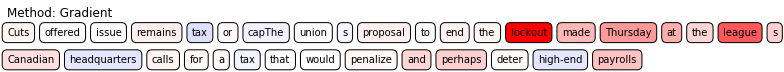

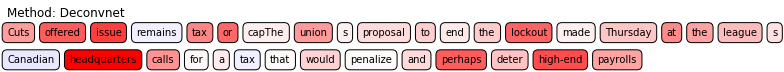

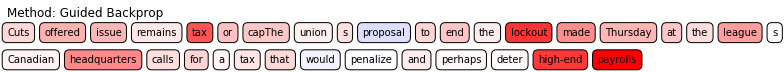

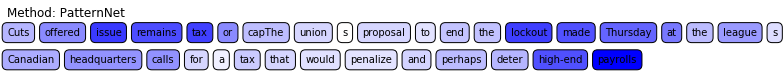

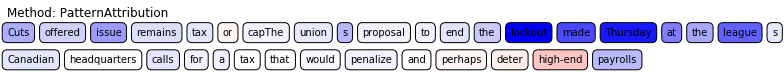

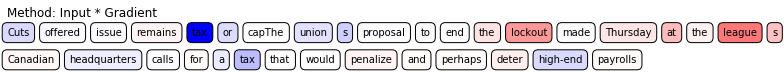

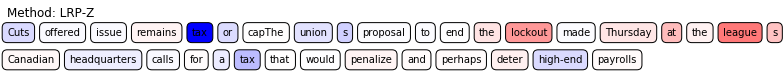

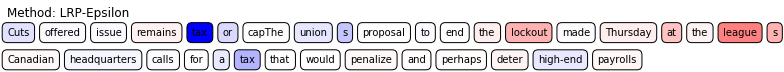

In [25]:
names = [method[2] for method in methods]
for i, idx in enumerate(test_sample_paths):
    words = dset[idx]['text']   
    for j, method in enumerate(methods):
        plot_text_heatmap(words, analysis[i, j].reshape(-1), norm=2, title='Method: %s' % names[j], verbose=0)
        plt.show()
        #print(analysis[i,j])

In [26]:
x = dset[test_sample_paths[0]]['matrix']
x = x.reshape((1, -1, 300,1)).numpy() 
print(k_model.predict(x))
x = x.reshape((1, 1,-1, 300)) 
model(torch.as_tensor(x).to(device, dtype=torch.float))

[[-2.3271759 -1.050967   2.182714  -4.7001305]]


tensor([[-2.3272, -1.0510,  2.1827, -4.7001]], device='cuda:0')

In [23]:
test_sample_paths = []
for i in range(240):
    test_sample_paths.append(pths[i//60][i%60])


analyzis = [[None]*len(analyzers)]*len(test_sample_paths)

for i, ridx in enumerate(test_sample_paths):
 
    x = dset[ridx]['matrix']
    x = x.reshape((1, -1, 300,1)).numpy()    
    analyzis[i] = [np.zeros(x.shape[1])]*len(analyzers)
    
    for aidx, analyzer in enumerate(analyzers):        
        a = np.squeeze(analyzer.analyze(x,neuron_selection=(i//60)))
        a = np.sum(a, axis=1)
        analyzis[i][aidx] = a   

In [30]:
###### ACC GRAPH
def get_acc_batched(x,target,maps):
    BTCH = 64
    yval = [None]*len(maps)
    for i in range(len(maps)):
        
        yval[i] = np.zeros(11)
        
        n = vec_trans.matrixify('a',1)
        n = np.tile(n,(64,1,x.shape[0],1))
        for it in range(64):
            n[it] = np.tile(vec_trans.matrixify(prep[it],1),(1,1,x.shape[0],1))
        #n = torch.as_tensor(n.astype(np.float32)).to(device)
        
        order = np.argsort(maps[i])[::-1]
        xt = x[None,None,:,:]
        xt = np.tile(xt,(BTCH,1,1,1))
        with torch.no_grad():
            for k in range(1,11):
                xt[:,0,order[:k],:] = n[:,0,order[:k],:] 
                out = model(torch.as_tensor(xt.astype(np.float32)).to(device))
                highest_dim = np.argmax(out.cpu().numpy(), axis=1)
                temp = [int(x==target) for x in highest_dim]
                yval[i][k] = sum(temp)/BTCH
            yval[i][0] = 1
    return yval

###### ACC GRAPH
def get_acc_zero(x,target,maps):
    BTCH = 1

    yval = [None]*len(maps)
    for i in range(len(maps)):
        
        yval[i] = np.zeros(11)
        
        n = np.zeros((BTCH,1,x.shape[0],300))
        order = np.argsort(maps[i])[::-1]
        xt = x[None,None,:,:]
        xt = np.tile(xt,(BTCH,1,1,1))
                
        with torch.no_grad():
            for k in range(1,11):
                xt[:,0,order[:k],:] = n[:,0,order[:k],:] 
                out = model(torch.as_tensor(xt.astype(np.float32)).to(device))
                highest_dim = np.argmax(out.cpu().numpy(), axis=1)
                temp = [int(x==target) for x in highest_dim]
                yval[i][k] = sum(temp)/BTCH
            yval[i][0] = 1
    return yval

In [25]:
N_PC=60

ybf_acc=[[np.zeros(11)]*7]*240
yba_acc=[[np.zeros(11)]*3]*240
ybgd_acc = [[np.zeros(11)]]*240
ybl_acc = [[np.zeros(11)]]*240
yoth_acc = [[np.zeros(11)]*len(analyzers)]*240

mf = [None]*7
ma = [None]*3

#yzf_acc=[[np.zeros(11)]*7]*240
#yza_acc=[[np.zeros(11)]*3]*240
#yzgd_acc = [[np.zeros(11)]]*240
#mz = [None]*10

for i in range(60):
    for j in range(4):
        x = dset[pths[j][i]]['matrix'].numpy()
        
        for k in range(7):
            mf[k] = rmap_f[k][j][i]
        ybf_acc[j*N_PC + i] = get_acc_batched(x,j,mf)
        #yzf_acc[j*N_PC + i] = get_acc_zero(x,j,mf)
        
        ybgd_acc[j*N_PC + i] = get_acc_batched(x,j,[rmap_g[j][i]])
        #yzgd_acc[j*N_PC + i] = get_acc_zero(x,j,[rmap_g[j][i]])
        
        ybl_acc[j*N_PC + i] = get_acc_batched(x,j,[rmap_l[j][i]])
        
        for k in range(3):
            ma[k] = rmap_a[k][j][i]
        yba_acc[j*N_PC + i] = get_acc_batched(x,j,ma)
        
        yoth_acc[j*N_PC + i] = get_acc_batched(x,j,analyzis[j*N_PC+i])
    if i%10==0:
        print(i)
        
        

0
10
20
30
40
50


In [26]:
z = np.array(ybf_acc)
ybf_am = z.mean(axis=0)

z = np.array(ybgd_acc)
ybgd_am = z.mean(axis=0)

z = np.array(ybl_acc)
ybl_am = z.mean(axis=0)


z = np.array(yba_acc)
yba_am = z.mean(axis=0)

z = np.array(yoth_acc)
yoth_am = z.mean(axis=0)


['Input * Gradient' 'LRP-Z' 'LRP-Epsilon' 'PatternAttribution'
 'Guided Backprop' 'Gradient' 'Deconvnet' 'DeepTaylor' 'PatternNet']


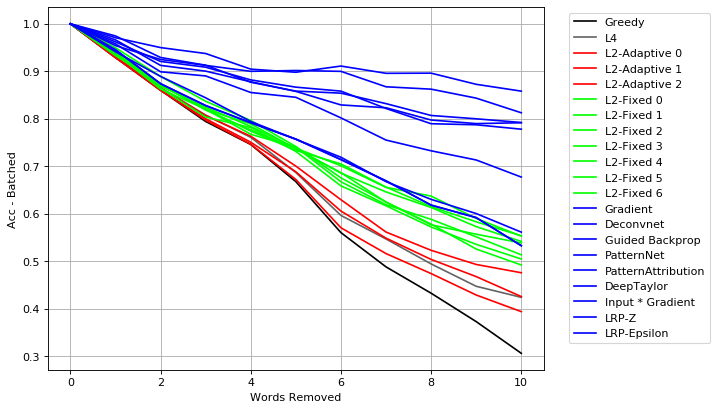

In [39]:
colors = ['#000000','#636363']+3*['#FF0000']+7*['#00FF00']+len(analyzers)*['#0000FF'] #,'#0000FF','#0000FF','#0000FF','#0000FF']
          #'#a8ddb5','#606060','#4eb3d3','#7bccc4','#a8ddb5','#ccebc5']

#fig = plt.figure()
#ax = plt.subplot(111)

    
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(ybgd_am[0],colors[0],label='Greedy')

plt.plot(ybl_am[0],colors[1],label='L4')


for i in range(yba_am.shape[0]):
    plt.plot(yba_am[i],colors[2+i],label='L2-Adaptive '+str(i))

for i in range(ybf_am.shape[0]):
    plt.plot(ybf_am[i],colors[5+i],label='L2-Fixed '+str(i))

for i in range(yoth_am.shape[0]):
    plt.plot(yoth_am[i],colors[12+i], label = names[i])
    
#plt.legend()

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.grid(True)
plt.xlabel('Words Removed')
plt.ylabel('Acc - Batched')

z = np.argsort(yoth_am[:,-1])
names = np.array(names)
print(names[z])

# Brute Force Algorithm

In [ ]:
def brutus(x,n_current,n_total,indices_done,check_set):
    global final_list
    global final_acc
    
    print(n_current,indices_done,check_set)
    with torch.no_grad():
        if n_current == n_total:
            x = x.to(device)
            out = model(x)
            acc = torch.mean(out,dim=0)[target].cpu().numpy()#1.0*sum(temp)/64.0
            if acc< final_acc:
                final_acc = acc
                final_list = indices_done
            x = x.cpu()
        else:
            for i in check_set:
                if not indices_done:
                    z = x.clone()
                    z[:,:,i,:] = torch.zeros((1,1,300))
                    #print(indices_done,i,n_current,'FUUU')
                    brutus(z,n_current+1,n_total,[i],check_set)
                elif i not in indices_done:
                    z = x.clone()
                    z[:,:,i,:] = torch.zeros((1,1,300))
                    l = indices_done.copy()
                    #print(l,indices_done,i)
                    l.append(i)
                    #print(l)
                    brutus(z,n_current+1,n_total,l,check_set)

# Misclassified 

In [9]:
rand_files = random.sample(range(len(dset)), len(dset))

N_PC = 10

N_AB = 7  #Num of fixed lambda rmap
N_AD = 3  #Num of adaptive lambda rmap

LAMS = [0, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
RANG = [(0.04,0.1),(0.12,0.25),(0.25,0.45)]

cmap_f = [None]*N_AB
for i in range(N_AB):
    cmap_f[i] = [None]*4
    for j in range(4):
        cmap_f[i][j] = [0]*N_PC

cmap_a = [None]*N_AD
for i in range(N_AD):
    cmap_a[i] = [None]*4
    for j in range(4):
        cmap_a[i][j] = [0]*N_PC

        
cmap_g = [None]*4  #By Greedy Algo
cmap_l = [None]*4  

metaD = [None]*4

for x in range(4):
    metaD[x] = [0]*N_PC
    cmap_g[x] = [0]*N_PC
    cmap_l[x] = [0]*N_PC
    
counter = [0]*4
_ = 0
c_ = 0

while not all(x == N_PC for x in counter):
    
    x = dset[rand_files[_]]
    e = x['text']
    LE = len(e)
    sample = x['matrix']
    target = int(x['class'])
    
    if len(e)<25 or len(e)>80:
        _ += 1
        continue
    
    sample = sample[None,None,:,:]
    
    x_input = torch.as_tensor(sample).to(device, dtype=torch.float)
    x_out = model(x_input.clone()).detach().cpu()
    
    _ += 1
    
    predicted = int(np.argmax(x_out))
    
    if predicted == target:    
        continue
        
    if counter[target] == N_PC:
        continue
    
    print(counter)
    c_ += 1
    
    ## Greedy
    #print(LE)
    #print(list(range(LE)))
    ind = GenRelMap_GreedyOpt_Fast(sample, list(range(LE)), num=10)
    rel = np.zeros(sample.shape[2])
    rel[ind] = range(1,11)[::-1]
    
    cmap_g[target][counter[target]] = rel

    
    ## Fixed L
    length = 20
    for it,LAM in enumerate(LAMS):
        guider = GenRelMap_LF(sample, mode=5, num_iters=701, gam=0.995, lr = 8e-3, lamb= LAM)[0,:,0]
        guider[LE:] = np.zeros((80-LE))
        z = np.argsort(guider)[::-1]
        ind = GenRelMap_GreedyOpt_Fast(sample, z[:length], num=10)
        rel = np.zeros(sample.shape[2])
        rel[ind] = range(1,11)[::-1]
        cmap_f[it][target][counter[target]] = rel

    
    ## Adaptive L
    lamb = 30
    for it,RAN in enumerate(RANG):
        guider, lamb = GenRelMap_LF(sample, mode=2, num_iters=701, gam=0.995, lr = 5e-3, lamb=lamb, maxi=RAN[1],mini=RAN[0])
        guider = guider[0,:,0]
        guider[LE:] = np.zeros((80-LE))
        z = np.argsort(guider)[::-1]
        ind = GenRelMap_GreedyOpt_Fast(sample, z[:length], num=10)
        rel = np.zeros(sample.shape[2])
        rel[ind] = range(1,11)[::-1]
        cmap_a[it][target][counter[target]] = rel

    
    guider = GenRelMap_LF(sample, mode=4, num_iters=701, gam=0.995, lr = 8e-3)[0,:,0]
    guider[LE:] = np.zeros((80-LE))
    z = np.argsort(guider)[::-1]
    ind = GenRelMap_GreedyOpt_Fast(sample, z[:length], num=10)
    rel = np.zeros(sample.shape[2])
    rel[ind] = range(1,11)[::-1]
    cmap_l[target][counter[target]] = rel

    
    metaD[target][counter[target]] = (e,predicted,rand_files[_-1])
    
    counter[target] += 1 
    
    if c_%20==0:
        print('##### At '+str(c_))
        np.save('relmap_data/data_C_'+str(c_)+'.npy',[cmap_f,cmap_a,cmap_g,cmap_l,metaD])

[0, 0, 0, 0]
30
1.875
15.9375
15.9375
0.99609375
0.99609375
0.062255859375
[0, 0, 0, 1]
30
1.875
15.9375
3.3552631578947367
3.3552631578947367
0.20970394736842105
1.782483552631579
0.37525969529085873
0.37525969529085873
0.02345373095567867
[0, 0, 1, 1]
30
1.875
15.9375
3.3552631578947367
9.646381578947368
9.646381578947368
0.6028988486842105
0.6028988486842105
0.03768117804276316
[0, 0, 2, 1]
30
1.875
15.9375
3.3552631578947367
3.3552631578947367
0.20970394736842105
1.782483552631579
1.782483552631579
0.11140522203947369
[0, 0, 3, 1]
30
1.875
15.9375
3.3552631578947367
9.646381578947368
9.646381578947368
0.6028988486842105
0.6028988486842105
0.03768117804276316
[0, 0, 4, 1]
30
1.875
1.875
0.1171875
0.99609375
0.20970394736842105
0.6028988486842105
0.6028988486842105
0.03768117804276316
[1, 0, 4, 1]
30
1.875
15.9375
3.3552631578947367
3.3552631578947367
0.20970394736842105
0.20970394736842105
0.013106496710526315
[1, 0, 5, 1]
30
1.875
1.875
0.1171875
0.99609375
0.99609375
0.06225585937

In [27]:
test_sample_paths = []
for i in range(40):
    test_sample_paths.append(metaD[i//10][i%10][2])


analyzis = [[None]*len(analyzers)]*len(test_sample_paths)

for i, ridx in enumerate(test_sample_paths):
 
    x = dset[ridx]['matrix']
    x = x.reshape((1, -1, 300,1)).numpy()    
    analyzis[i] = [np.zeros(x.shape[1])]*len(analyzers)
    
    for aidx, analyzer in enumerate(analyzers):        
        a = np.squeeze(analyzer.analyze(x,neuron_selection=(i//10)))
        a = np.sum(a, axis=1)
        analyzis[i][aidx] = a   

In [34]:
###### ACC GRAPH
def get_acc_batched_v2(x,target,maps):
    BTCH = 64
    yval = [None]*len(maps)
    for i in range(len(maps)):
        
        yval[i] = np.zeros(11)
        
        n = vec_trans.matrixify('a',1)
        n = np.tile(n,(64,1,x.shape[0],1))
        for it in range(64):
            n[it] = np.tile(vec_trans.matrixify(prep[it],1),(1,1,x.shape[0],1))
        #n = torch.as_tensor(n.astype(np.float32)).to(device)
        
        order = np.argsort(maps[i])[::-1]
        xt = x[None,None,:,:]
        xt = np.tile(xt,(BTCH,1,1,1))
        with torch.no_grad():
            for k in range(1,11):
                xt[:,0,order[:k],:] = n[:,0,order[:k],:] 
                out = model(torch.as_tensor(xt.astype(np.float32)).to(device))
                highest_dim = np.argmax(out.cpu().numpy(), axis=1)
                temp = [int(x==target) for x in highest_dim]
                yval[i][k] = sum(temp)/BTCH
            yval[i][0] = 0
    return yval

In [36]:
N_PC=10

ybf_acc=[[np.zeros(11)]*7]*40
yba_acc=[[np.zeros(11)]*3]*40
ybgd_acc = [[np.zeros(11)]]*40
ybl_acc = [[np.zeros(11)]]*40
yoth_acc = [[np.zeros(11)]*len(analyzers)]*40

mf = [None]*7
ma = [None]*3

for i in range(10):
    for j in range(4):
        x = dset[metaD[j][i][2]]['matrix'].numpy()
        
        for k in range(7):
            mf[k] = cmap_f[k][j][i]
        ybf_acc[j*N_PC + i] = get_acc_batched_v2(x,j,mf)
        
        ybgd_acc[j*N_PC + i] = get_acc_batched_v2(x,j,[cmap_g[j][i]])
        
        ybl_acc[j*N_PC + i] = get_acc_batched_v2(x,j,[cmap_l[j][i]])
        
        for k in range(3):
            ma[k] = cmap_a[k][j][i]
        yba_acc[j*N_PC + i] = get_acc_batched_v2(x,j,ma)
        
        yoth_acc[j*N_PC + i] = get_acc_batched_v2(x,j,analyzis[j*N_PC+i])
    

In [37]:
z = np.array(ybf_acc)
ybf_am = z.mean(axis=0)

z = np.array(ybgd_acc)
ybgd_am = z.mean(axis=0)

z = np.array(ybl_acc)
ybl_am = z.mean(axis=0)


z = np.array(yba_acc)
yba_am = z.mean(axis=0)

z = np.array(yoth_acc)
yoth_am = z.mean(axis=0)


['Input * Gradient' 'LRP-Z' 'LRP-Epsilon' 'Gradient' 'PatternNet'
 'PatternAttribution' 'Deconvnet' 'Guided Backprop']


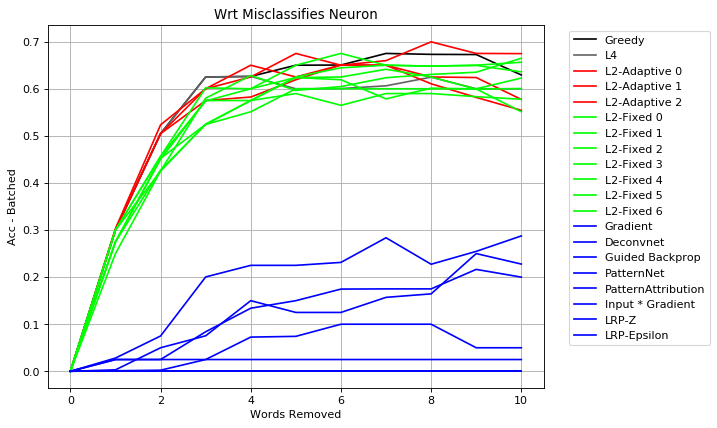

In [38]:
colors = ['#000000','#636363']+3*['#FF0000']+7*['#00FF00']+len(analyzers)*['#0000FF'] #,'#0000FF','#0000FF','#0000FF','#0000FF']
          #'#a8ddb5','#606060','#4eb3d3','#7bccc4','#a8ddb5','#ccebc5']

#fig = plt.figure()
#ax = plt.subplot(111)

    
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(ybgd_am[0],colors[0],label='Greedy')

plt.plot(ybl_am[0],colors[1],label='L4')


for i in range(yba_am.shape[0]):
    plt.plot(yba_am[i],colors[2+i],label='L2-Adaptive '+str(i))

for i in range(ybf_am.shape[0]):
    plt.plot(ybf_am[i],colors[5+i],label='L2-Fixed '+str(i))

for i in range(yoth_am.shape[0]):
    plt.plot(yoth_am[i],colors[12+i], label = names[i])
    
#plt.legend()

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.grid(True)
plt.title('Wrt Misclassifies Neuron')
plt.xlabel('Words Removed')
plt.ylabel('Acc - Batched')

z = np.argsort(yoth_am[:,-1])
names = np.array(names)
print(names[z])